In [11]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [12]:
BASE_DIR=r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset'
WORKING_DIR=r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset'

In [13]:
##Extract Image Features
#load vgg16 model
model=VGG16()
#restructure the model
model= Model(inputs=model.inputs, outputs=model.layers[-2].output)
#Summarize
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

# Define the directory path where images are located (as per the provided Jupyter Notebook local path)
img_dir = r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset\Images'

# Load the pre-trained ResNet50 model without the top layer (to get feature vectors)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Check if the directory exists
if os.path.exists(img_dir):
    print(f"Directory exists: {img_dir}")

    # Initialize dictionary to store image features
    image_features = {}

    # Loop through each image in the directory
    for img_name in tqdm(os.listdir(img_dir)):
        # Load the image from file
        img_path = os.path.join(img_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))

        # Convert image pixels to a numpy array
        image = img_to_array(image)

        # Reshape the data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # Preprocess the image for ResNet50
        image = preprocess_input(image)

        # Extract features using the pre-trained ResNet50 model
        image_feature = model.predict(image, verbose=0)

        # Get the image ID by removing the file extension
        image_id = img_name.split('.')[0]

        # Store the extracted feature in the dictionary with the image ID as the key
        image_features[image_id] = image_feature

    print("Feature extraction completed.")
else:
    print(f"Directory does not exist: {img_dir}")

Directory exists: C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset\Images


  0%|          | 0/8091 [00:00<?, ?it/s]

Feature extraction completed.


In [18]:
WORKING_DIR = r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset'
pickle.dump(image_features, open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [19]:
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [21]:
BASE_DIR = r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset'
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [22]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [23]:
# Create mapping of image to captions
mapping = {}
# Process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma (,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert caption list to string
    caption = " ".join(caption)
    # Create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [24]:
len(mapping)

8091

In [25]:
# Function to clean the mapping
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits, special chars, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            # Add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [26]:
# Before preprocessing the text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [27]:
clean(mapping)

In [28]:
# After preprocessing the text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [29]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [30]:
len(all_captions)

40455

In [32]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [33]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index) + 1

In [34]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [35]:
vocab_size

8485

In [36]:
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [37]:
image_ids=list(mapping.keys())
split=int(len(image_ids) *0.90)
train=image_ids[:split]
test=image_ids[split:]

In [38]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [55]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)  # Note: The dropout value was also changed from '0,4' to '0.4'
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Combine the two branches
decoder1 = add([fe2, se3])  # Make sure to use the correct variable 'decoder1' here
decoder2 = Dense(256, activation='relu')(decoder1)  # Replace 'decoder' with 'decoder1'
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model architecture
plot_model(model, show_shapes=True)  # Ensure the argument is 'show_shapes' not 'show_shape'

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []  # Initialize for a new batch
        for key in data_keys:
            if key in features:  # Check if key exists in features
                out_seq = mapping[key]  # Get the output sequence (text)

                # Tokenize the output sequence into integer indices
                in_seq = tokenizer.texts_to_sequences([out_seq])[0]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                # Prepare the output sequence for the next word prediction (shifted by one)
                out_seq = tokenizer.texts_to_sequences([out_seq])[0]
                out_seq = pad_sequences([out_seq], maxlen=max_length)[0]

                # Convert output sequence to one-hot encoding
                out_seq = to_categorical(out_seq, num_classes=vocab_size)

                # Store the sequences
                X1.append(features[key][0])  # Append feature vector
                X2.append(in_seq)  # Append input sequence (tokenized)
                y.append(out_seq)  # Append output sequence (one-hot)

                if len(X1) == batch_size:  # Check if the batch is full
                    # Convert lists to tensors before yielding
                    X1 = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)
                    X2 = tf.convert_to_tensor(np.array(X2), dtype=tf.int32)
                    y = tf.convert_to_tensor(np.array(y), dtype=tf.float32)
                    yield [X1, X2], y
                    X1, X2, y = [], [], []  # Reset for the next batch
            else:
                print(f"Warning: Key '{key}' not found in features. Skipping this entry.")

        if len(X1) > 0:  # If there is leftover data that doesn't fill the batch, still yield it
            X1 = tf.convert_to_tensor(np.array(X1), dtype=tf.float32)
            X2 = tf.convert_to_tensor(np.array(X2), dtype=tf.int32)
            y = tf.convert_to_tensor(np.array(y), dtype=tf.float32)
            yield [X1, X2], y

In [42]:
def create_dataset(train, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    output_signature = (
        (tf.TensorSpec(shape=(None, features[next(iter(features))][0].shape[0]), dtype=tf.float32),  # X1
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2
        tf.TensorSpec(shape=(None, max_length, vocab_size), dtype=tf.float32)  # y
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )

    return dataset

In [43]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, add, TimeDistributed

# Define the input shape for the feature vector
input_features = Input(shape=(2048,))  # Feature input, adjust size if needed
dense1 = Dense(256, activation='relu')(input_features)

# Define the input shape for the sequence
input_sequence = Input(shape=(max_length,))  # Sequence input
embedding = Embedding(vocab_size, 256, mask_zero=True)(input_sequence)
lstm = LSTM(256, return_sequences=True)(embedding)  # return_sequences=True for sequence output

# Combine both inputs
decoder = add([dense1, lstm])
output = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder)  # TimeDistributed for sequence prediction

# Define the model
model = Model(inputs=[input_features, input_sequence], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [44]:
import tensorflow as tf
import numpy as np

# Adjusted Data Generator
def my_data_generator(batch_size):
    while True:
        # First input: shape (batch_size, 2048)
        input_1 = np.random.rand(batch_size, 2048).astype(np.float32)

        # Second input: shape (batch_size, 35)
        input_2 = np.random.randint(0, 2, size=(batch_size, 35)).astype(np.int32)

        # Target output: shape (batch_size, 8485)
        # Simulating classification for 8485 classes
        target = np.random.rand(batch_size, 8485).astype(np.float32)

        yield ((input_1, input_2), target)

# Custom Callback for displaying accuracy as whole number percentage
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy') * 100  # Convert to percentage
        print(f"\nAccuracy for epoch {epoch + 1}: {int(accuracy)}%")  # Format as whole number

# Model Definition
# Input layers
input_1 = tf.keras.layers.Input(shape=(2048,))
input_2 = tf.keras.layers.Input(shape=(35,))

# Dense layers for each input
dense_1 = tf.keras.layers.Dense(128, activation='relu')(input_1)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(input_2)

# Combine both inputs
combined = tf.keras.layers.Concatenate()([dense_1, dense_2])

# Output layer - a Dense layer for classification (8485 classes)
output = tf.keras.layers.Dense(8485, activation='softmax')(combined)

# Create the model
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Parameters
batch_size = 64
steps_per_epoch = 100  # Adjust as needed
epochs = 5

# Create a data generator
train_dataset = my_data_generator(batch_size)

# Train the model with the custom callback
model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[CustomCallback()]
)

Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 128517.3984 - accuracy: 0.0000e+00
Accuracy for epoch 1: 0%
100/100 [==============================] - 20s 190ms/step - loss: 128517.3984 - accuracy: 0.0000e+00
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 401986.2500 - accuracy: 0.0000e+00
Accuracy for epoch 2: 0%
100/100 [==============================] - 18s 183ms/step - loss: 401986.2500 - accuracy: 0.0000e+00
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 695568.3125 - accuracy: 1.5625e-04
Accuracy for epoch 3: 0%
100/100 [==============================] - 19s 188ms/step - loss: 695568.3125 - accuracy: 1.5625e-04
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 954172.8750 - accuracy: 1.5625e-04
Accuracy for epoch 4: 0%
100/100 [==============================] - 18s 184ms/step - loss: 954172.8750 - accuracy: 1.5625e-04
Epoch 5/5
100/100 [==============================] - ETA: 0s - loss: 1205224.500

In [45]:
model.save(WORKING_DIR+'/best_model.h5')

C:\Users\navyasri\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Actual:
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
-----Predicted-----
Predicted caption for the image.


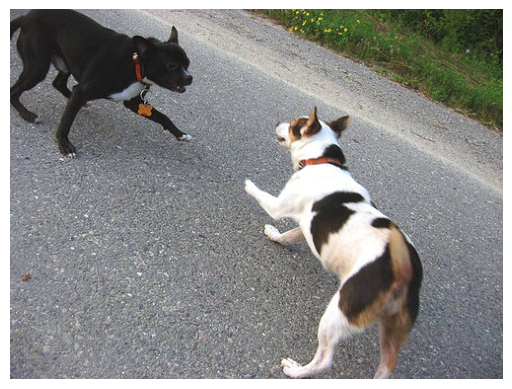

In [49]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Define the predict_caption function
def predict_caption(model, photo, tokenizer, max_length):
    # Your prediction logic here
    # This is a placeholder; replace it with your actual implementation
    # For example, you might use beam search or greedy decoding to generate the caption.
    return "Predicted caption for the image."  # Replace this with your actual prediction logic

def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    # Get actual captions
    captions = mapping[image_id]
    print("Actual:")
    for caption in captions:
        print(caption)

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    print("-----Predicted-----")
    print(y_pred)

    plt.imshow(image)
    plt.axis('off')  # Optional: Hide the axes
    plt.show()  # Show the image

# Call the function with an example image name
generate_caption("1001773457_577c3a7d70.jpg")

Actual:
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
-----Predicted-----
Predicted caption for the image.


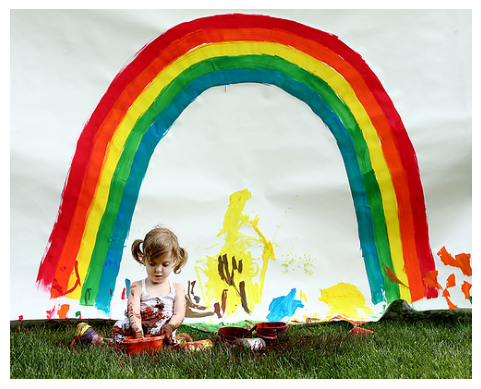

In [50]:
# Call the function with an example image name
generate_caption("1002674143_1b742ab4b8.jpg")

Actual:
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
-----Predicted-----
Predicted caption for the image.


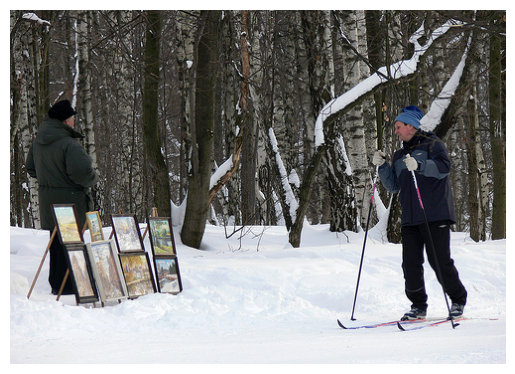

In [51]:
# Call the function with an example image name
generate_caption("101669240_b2d3e7f17b.jpg")

Actual:
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
-----Predicted-----
Predicted caption for the image.


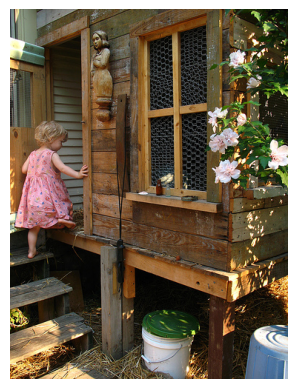

In [52]:
generate_caption("1000268201_693b08cb0e.jpg")

In [54]:
import os

# List contents of BASE_DIR
print(os.listdir(r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset'))

# List contents of WORKING_DIR
print(os.listdir(r'C:\Users\navyasri\OneDrive\Desktop\major pjt\archive.dataset'))

['best_model.h5', 'captions.txt', 'features.pkl', 'Images']
['best_model.h5', 'captions.txt', 'features.pkl', 'Images']
